## torchvision dataset 

In [2]:
import torchvision
data_dir = './images'
ann1 = 'v1_ann.json'
ann2 = 'v2_ann.json'
v1 = torchvision.datasets.CocoDetection(root=data_dir,annFile=ann1)
v2 = torchvision.datasets.CocoDetection(root=data_dir,annFile=ann2)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [3]:
import torchvision
data_dir = './images'
ann12 = 'annotations/v1v2_ann.json'
dt = torchvision.datasets.CocoDetection(root=data_dir,annFile=ann12)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## custom dt 0 (albumentation output)

In [24]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import os
import pycocotools

class BurnedCAD_is(Dataset):
    def __init__(self, root, annFile, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform # transform : albumentations
        self.root = root
        self.coco = pycocotools.coco.COCO(annFile)
        
        
        # dont refer to it
        # load label info
        self.cat_ids = self.coco.getCatIds() # category id [1,...,90]: len: 80, e.g, params: catNms=['person']
        self.cats = self.coco.loadCats(self.cat_ids) # [{'supercategory': 'person', 'id': 1, 'name': 'person'},...]
        
        self.classNameList = ['Backgroud'] # class name: ['Backgroud', 'person', 'bicycle',...], len:80
        for i in range(len(self.cat_ids)):
            self.classNameList.append(self.cats[i]['name'])
        
        #
        self.ids = list(sorted(self.coco.imgs.keys())) # [139, 285, 632, ...]
        
    def _load_image(self,id: int):
        path = self.coco.loadImgs(id)[0]["file_name"]
        image = cv2.imread(os.path.join(self.root, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # bgr > rgb
        return image
    
    def _load_target(self, id: int):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def _filter_targets(self,targets):
        # only seg. info.
        fil_targets = []
        for target in targets:
            if len(target['segmentation'])>0:
                target['category_id'] = 1 # 
                fil_targets.append(target)
        return fil_targets
        
    def unify_targets(self,targets):
        bboxes = []
        masks = []
        labels = []
        for target in targets:

            bbox = target['bbox']
            bboxes.append(bbox)

            coco_mask = target['segmentation']
            binary_mask = self.coco.annToMask(target)
            masks.append(binary_mask)

            label = target['category_id']
            labels.append(label)
        
        bboxes = np.array(bboxes).tolist() # np.array(bboxes)
        return bboxes, masks, labels
    
    def __getitem__(self, index: int):
        
        id = self.ids[index]
        image = self._load_image(id)
        targets = self._load_target(id)
        targets = self._filter_targets(targets)
        
        bboxes, masks, labels = self.unify_targets(targets)
        
        # masks  = np.array(masks)
        
        if (self.mode in ('train', 'val')):
           
            if self.transform is not None:
                
                transformed = self.transform(
                                    image=image,
                                    masks=masks,
                                    bboxes=bboxes,
                                    class_labels = labels
                                    # 'paste_image', 'paste_masks', 'paste_bboxes'
                                    )
                image = transformed["image"]
                masks = transformed["masks"]
                bboxes = transformed["bboxes"]
                labels = transformed["class_labels"]
                
                y = {'labels':labels, 'bboxes':bboxes, 'masks' : masks}
            
            else:
                y = {'labels':labels, 'bboxes':bboxes, 'masks' : masks}
            
            return image, y # , image_infos
        
        if self.mode == 'test':
            if self.transform is not None:
                transformed = self.transform(image=image)
                image = transformed["image"]
            return image # , image_infos
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds()) # 전체 dataset의 size 반환 

    

In [25]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
bcad_img = './images'
bcad_ann = './annotations/v1v2_ann.json'

trtf = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                ToTensorV2()
                ], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels'])
                )
                


valtf = A.Compose([
                  ToTensorV2()
                  ])

tetf = A.Compose([
                  ToTensorV2()
                  ])
trdt = BurnedCAD_is(root=bcad_img,annFile=bcad_ann, mode='train', transform=trtf)



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [28]:
trdt[0]

{'labels': [1],
 'bboxes': [(249.97, 97.93, 88.85999999999993, 46.94)],
 'masks': [tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)]}

## custom dt 1 (appropriate for pennfudan dataset)

In [105]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import os
import pycocotools

class BurnedCAD_is(Dataset):
    def __init__(self, root, annFile, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform # transform : albumentations
        self.root = root
        self.coco = pycocotools.coco.COCO(annFile)
        
        
        # dont refer to it
        # load label info
        self.cat_ids = self.coco.getCatIds() # category id [1,...,90]: len: 80, e.g, params: catNms=['person']
        self.cats = self.coco.loadCats(self.cat_ids) # [{'supercategory': 'person', 'id': 1, 'name': 'person'},...]
        
        self.classNameList = ['Backgroud'] # class name: ['Backgroud', 'person', 'bicycle',...], len:80
        for i in range(len(self.cat_ids)):
            self.classNameList.append(self.cats[i]['name'])
        
        # only seg. info
        self.ids = list(sorted(self.coco.imgs.keys())) # [139, 285, 632, ...]
        fil_ids = []
        for _id in self.ids:
            targets = self._load_target(_id)
            fil_targets = self._filter_targets(targets)
            if len(fil_targets) > 0:
                fil_ids.append(_id)
        self.ids = fil_ids
        
        
        
    def _load_image(self,id: int):
        path = self.coco.loadImgs(id)[0]["file_name"]
        image = cv2.imread(os.path.join(self.root, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # bgr > rgb
        return image
    
    def _load_target(self, id: int):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def _filter_targets(self,targets):
        # only seg. info.
        fil_targets = []
        for target in targets:
            if len(target['segmentation'])>0:
                target['category_id'] = 1 # 
                fil_targets.append(target)
        return fil_targets
        
    def unify_targets(self,targets):
        bboxes = []
        masks = []
        labels = []
        for target in targets:

            bbox = target['bbox']
            bboxes.append(bbox)

            coco_mask = target['segmentation']
            binary_mask = self.coco.annToMask(target)
            masks.append(binary_mask)

            label = target['category_id']
            labels.append(label)
        
        bboxes = np.array(bboxes).tolist() # np.array(bboxes)
        return bboxes, masks, labels
    
    def __getitem__(self, index: int):
        
        id = self.ids[index]
        image = self._load_image(id)
        targets = self._load_target(id)
        targets = self._filter_targets(targets)
        bboxes, masks, labels = self.unify_targets(targets)
        # masks  = np.array(masks)
        
        if (self.mode in ('train', 'val')):
           
            if self.transform is not None:
                
                transformed = self.transform(
                                    image=image,
                                    masks=masks,
                                    bboxes=bboxes,
                                    class_labels = labels
                                    # 'paste_image', 'paste_masks', 'paste_bboxes'
                                    )
                
                image = transformed["image"]
                masks  = torch.stack(transformed["masks"])
                bboxes = torch.tensor(transformed["bboxes"], dtype=torch.float32)[:,:4]
                image_id = torch.tensor([id])

                if bboxes.shape[0] == 0:
                    return self.__getitem__(idx+1)
                # area = torch.tensor([t['area'] for t in targets],dtype=torch.float32)
                # area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
                area = bboxes[:,2]*bboxes[:,3]
                iscrowd = torch.zeros((len(bboxes),), dtype=torch.int64)
                labels = torch.tensor(transformed["class_labels"],dtype=torch.int64)
                

                y = {
                    'boxes' : bboxes,
                    'labels':labels, 
                    'masks' : masks,
                    'image_id': image_id, #
                    'area': area,
                    'iscrowd':iscrowd
                    }
                
            else:
                y = {'labels':labels, 'bboxes':bboxes, 'masks' : masks}
            
            return image, y # , image_infos
        
        if self.mode == 'test':
            if self.transform is not None:
                transformed = self.transform(image=image)
                image = transformed["image"]
            return image # , image_infos
    
    def __len__(self) -> int:
        return len(self.ids) # 전체 dataset의 size 반환 


In [106]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
bcad_img = './images'
bcad_ann = './annotations/v1v2_ann.json'

trtf = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                ToTensorV2(),
                A.Normalize(),
                ], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels'])
                )
                


valtf = A.Compose([
                  A.Normalize(),
                  ToTensorV2()
                  ])

tetf = A.Compose([
                  A.Normalize(),
                  ToTensorV2()
                  ])
trdt = BurnedCAD_is(root=bcad_img,annFile=bcad_ann, mode='train', transform=trtf)



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [101]:
import torchshow as ts

In [109]:
trdt[0]

(tensor([[[54, 52, 52,  ..., 16, 16, 16],
          [52, 51, 51,  ..., 16, 16, 16],
          [52, 48, 48,  ..., 14, 14, 16],
          ...,
          [17, 19, 21,  ...,  0,  0,  0],
          [16, 17, 18,  ...,  0,  0,  0],
          [17, 21, 22,  ...,  0,  0,  0]],
 
         [[57, 55, 55,  ..., 16, 17, 17],
          [55, 54, 54,  ..., 16, 16, 16],
          [55, 51, 51,  ..., 14, 14, 16],
          ...,
          [20, 22, 23,  ...,  1,  1,  1],
          [19, 20, 21,  ...,  1,  0,  0],
          [20, 23, 23,  ...,  2,  0,  0]],
 
         [[54, 52, 52,  ..., 16, 14, 14],
          [52, 50, 50,  ..., 16, 16, 16],
          [52, 48, 48,  ..., 14, 14, 16],
          ...,
          [17, 19, 20,  ...,  0,  0,  0],
          [15, 17, 18,  ...,  0,  0,  0],
          [17, 20, 20,  ...,  0,  0,  0]]], dtype=torch.uint8),
 {'boxes': tensor([[301.1700,  97.9300,  88.8600,  46.9400]]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],


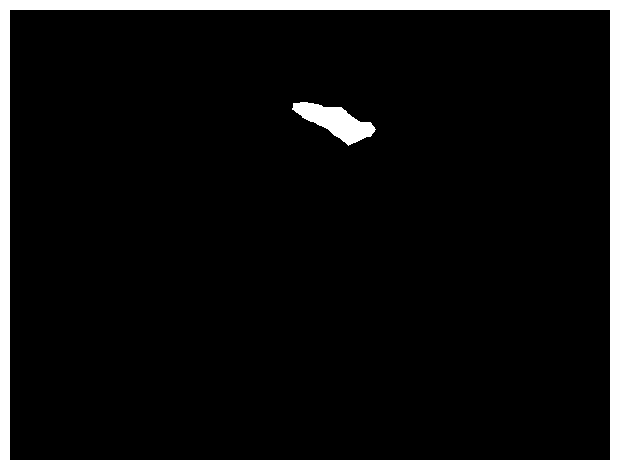

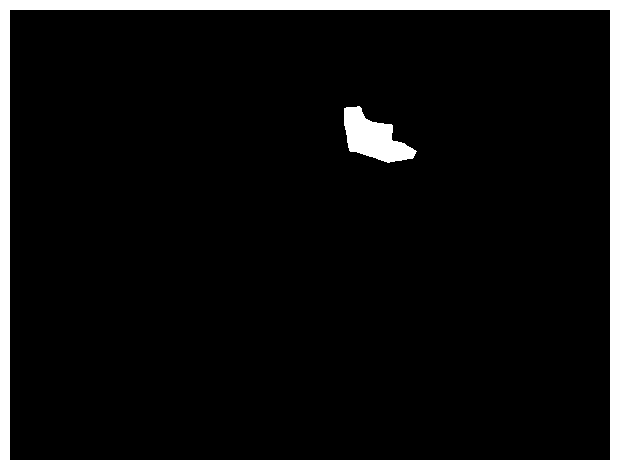

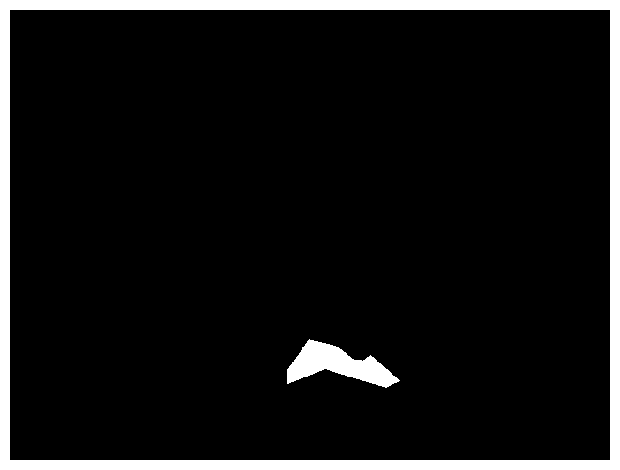

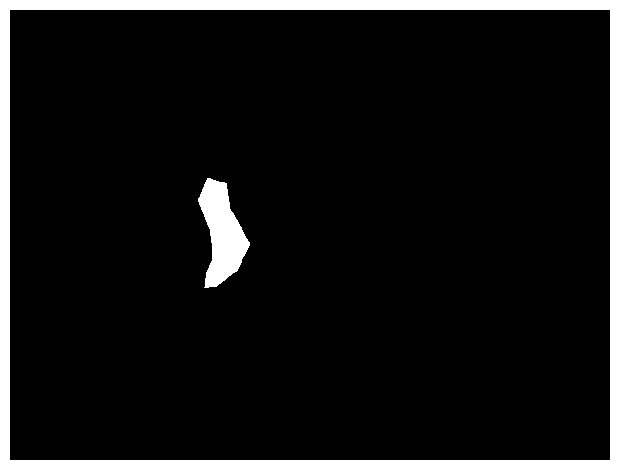

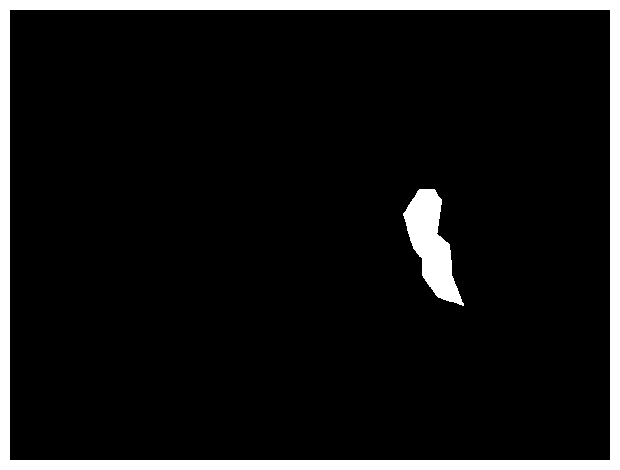

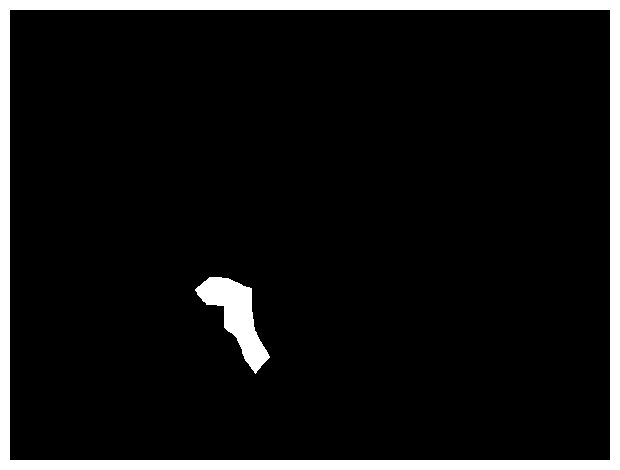

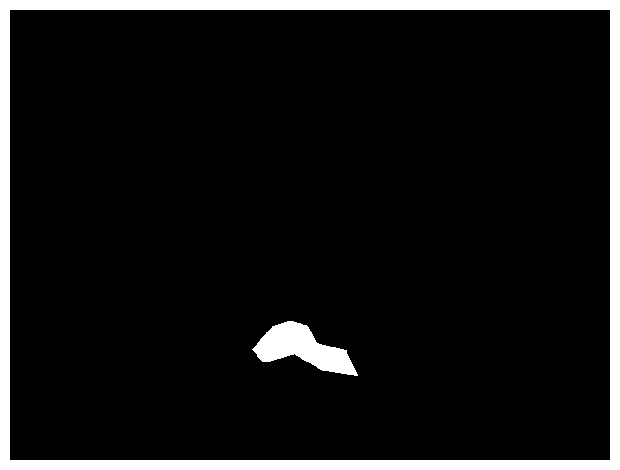

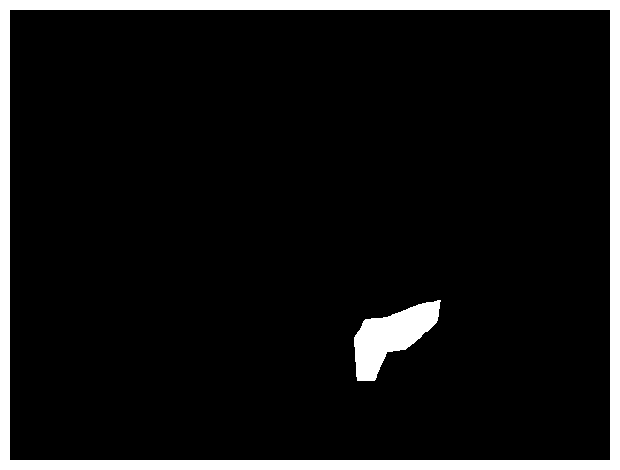

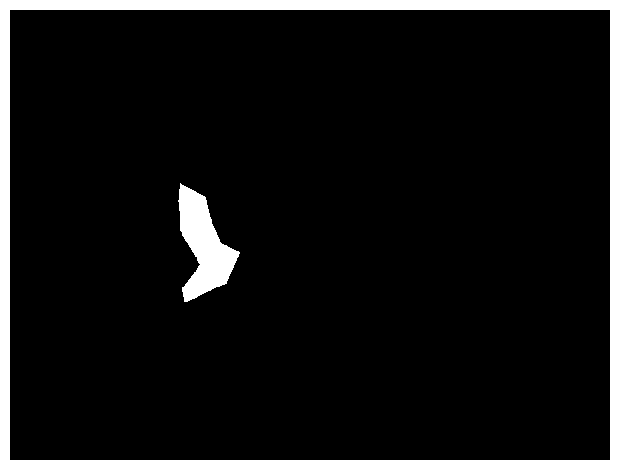

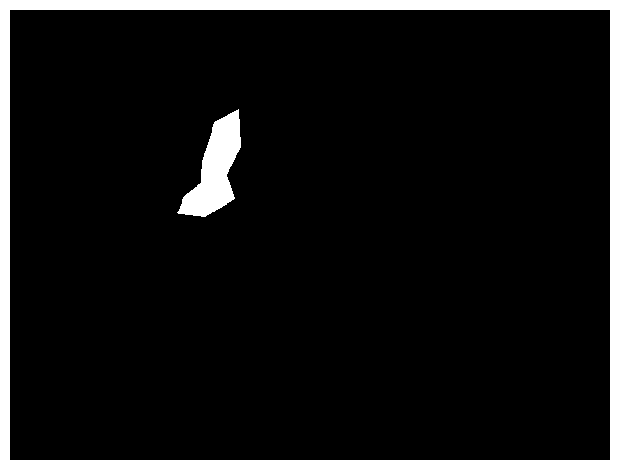

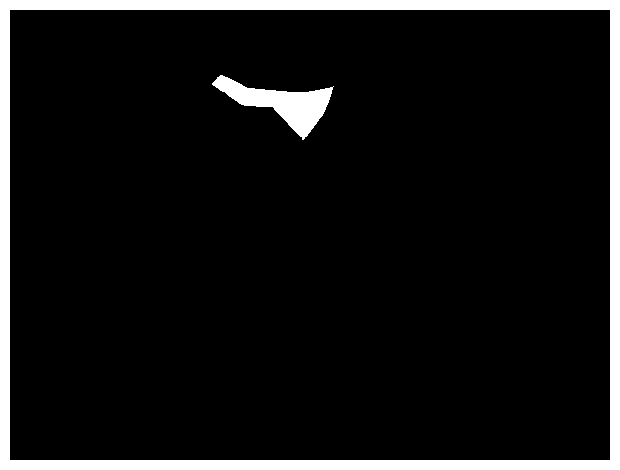

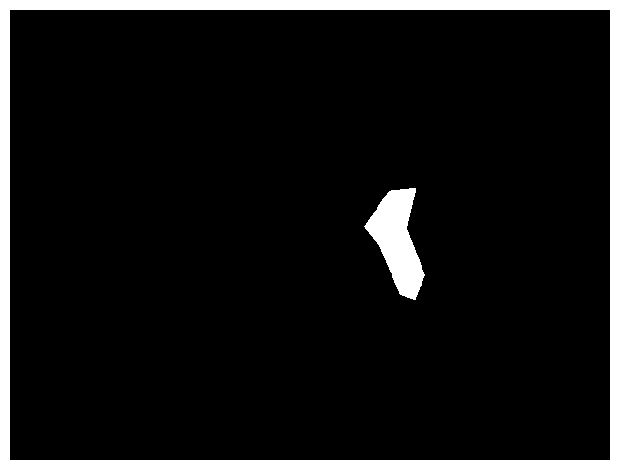

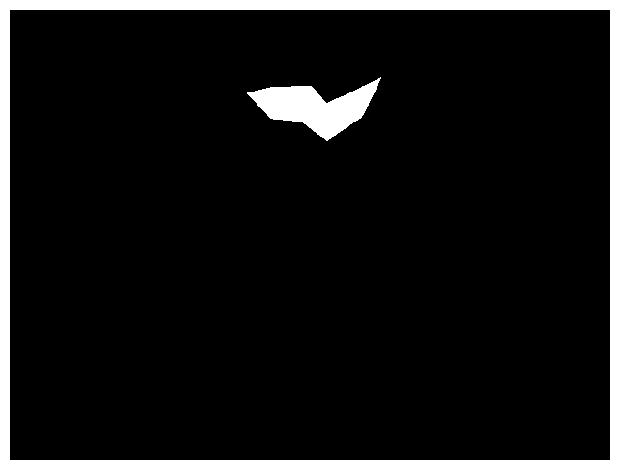

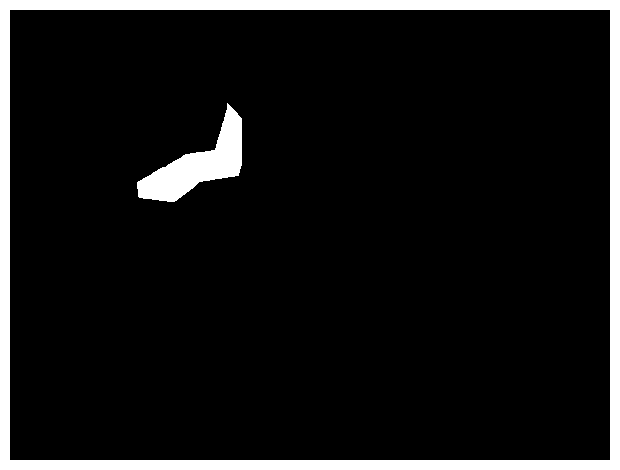

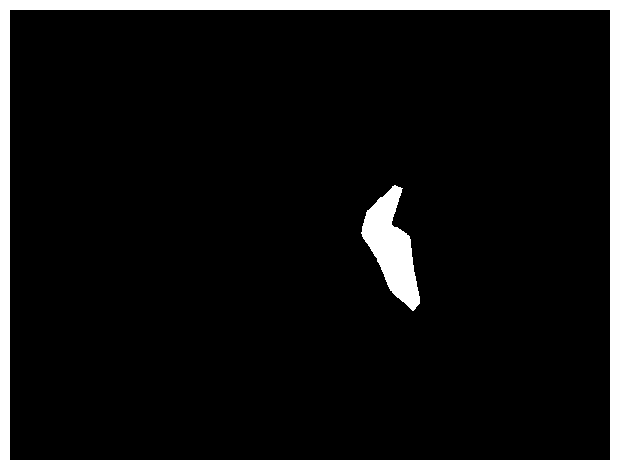

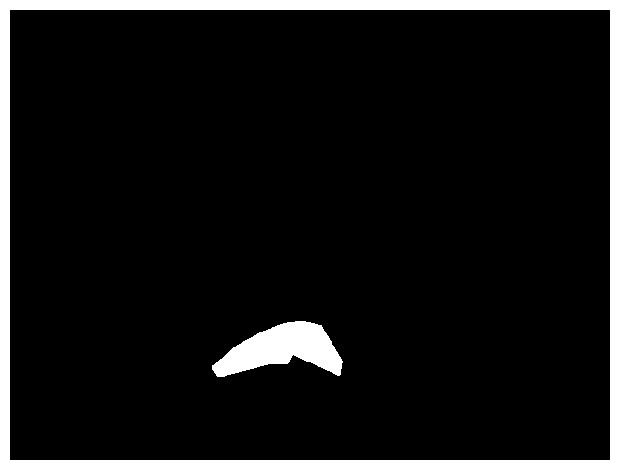

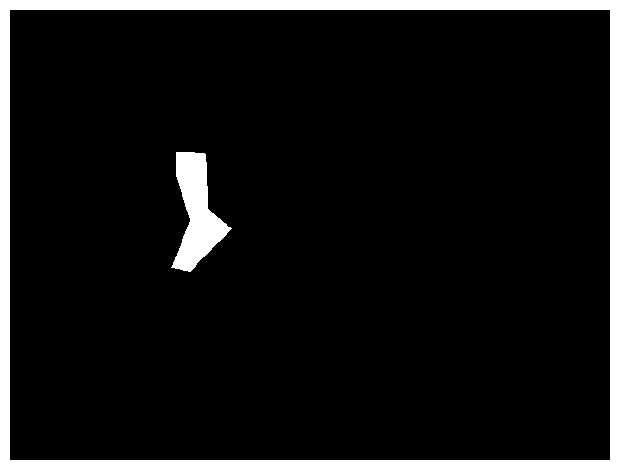

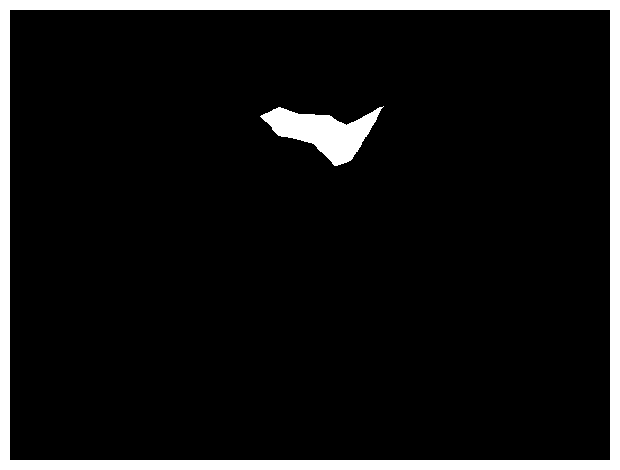

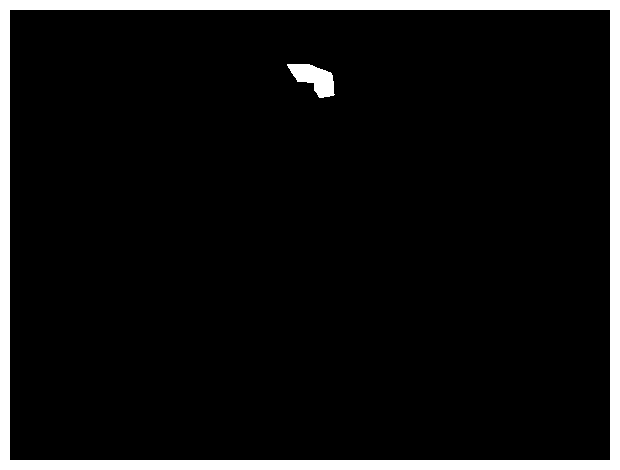

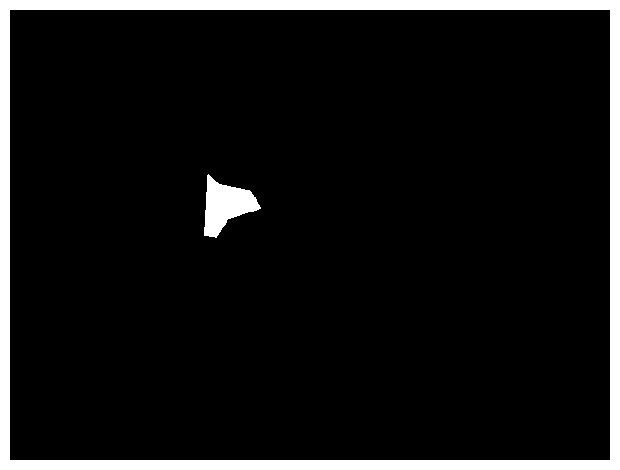

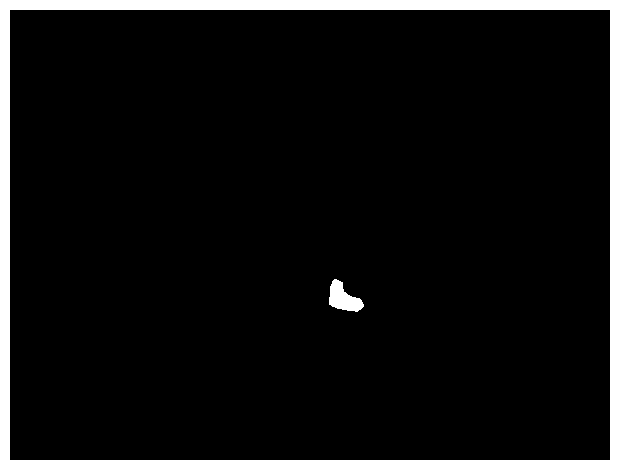

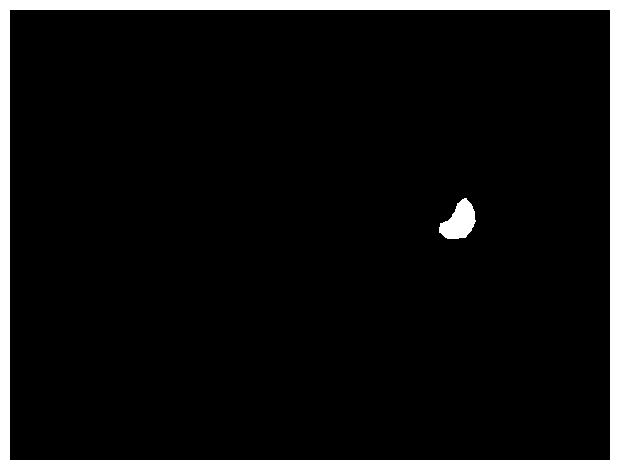

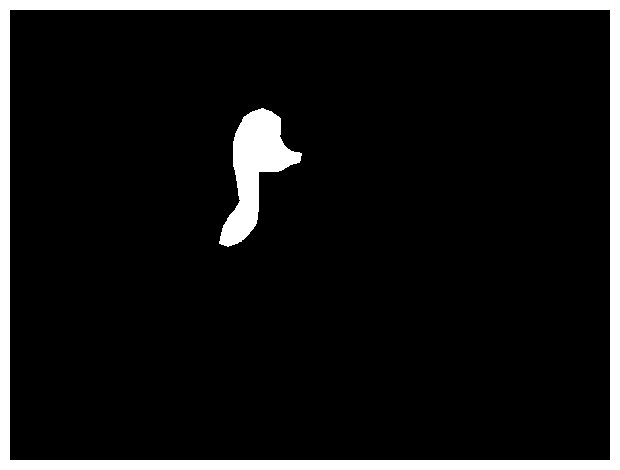

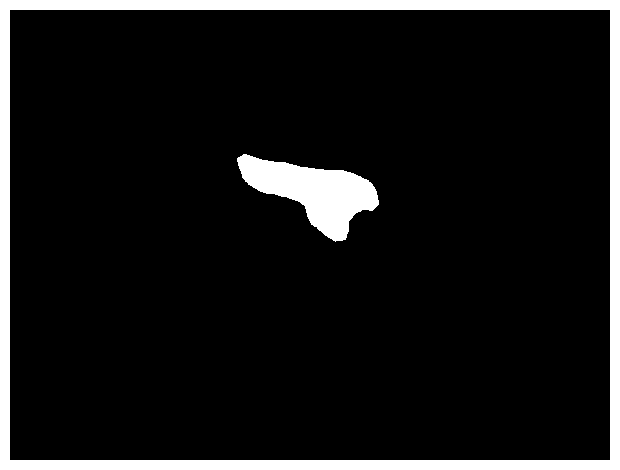

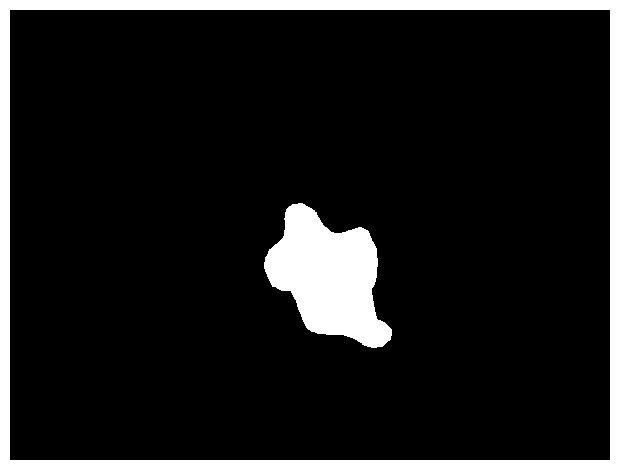

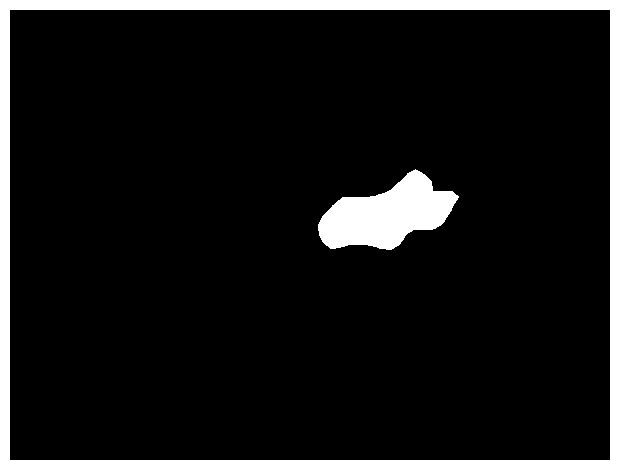

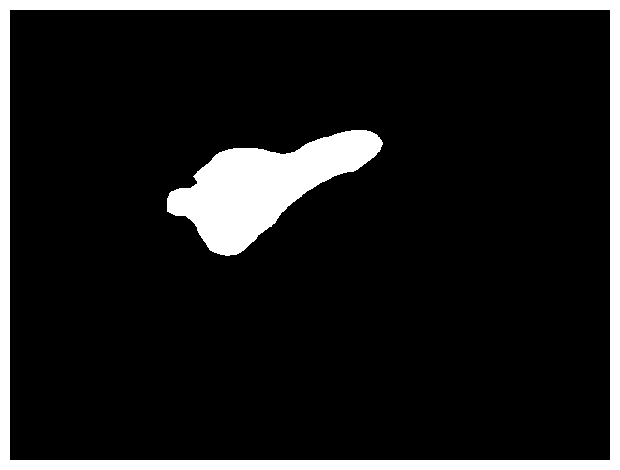

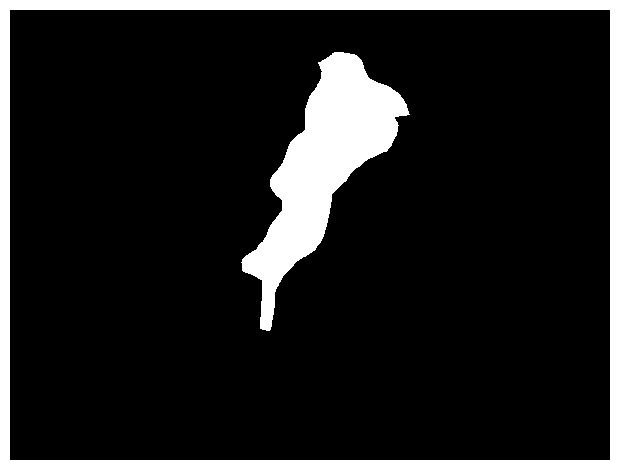

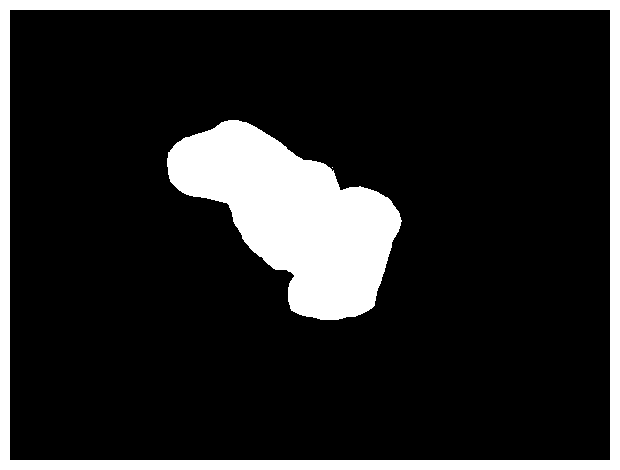

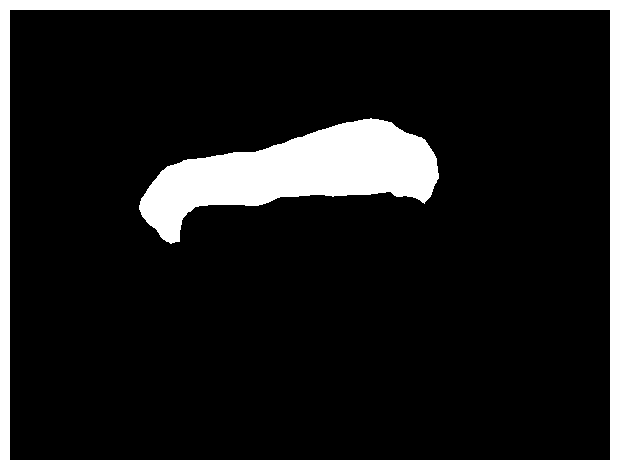

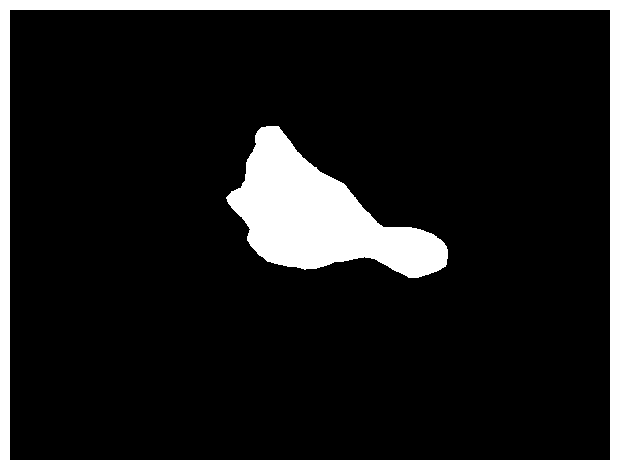

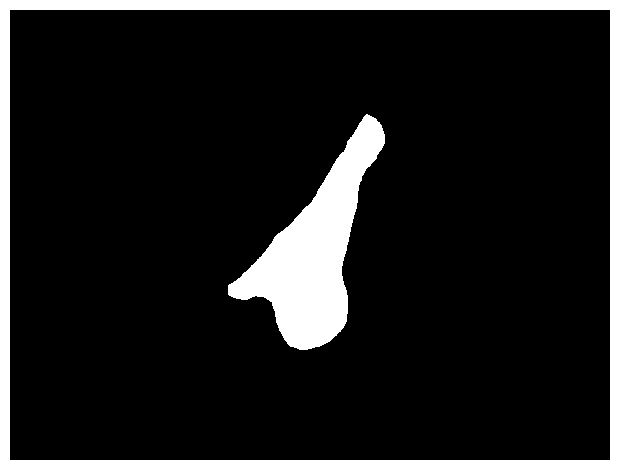

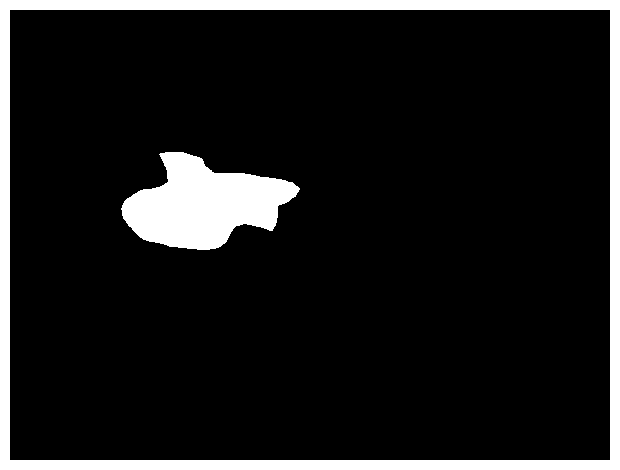

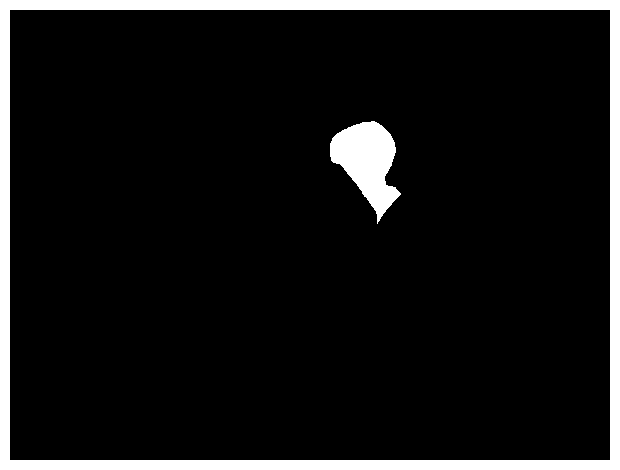

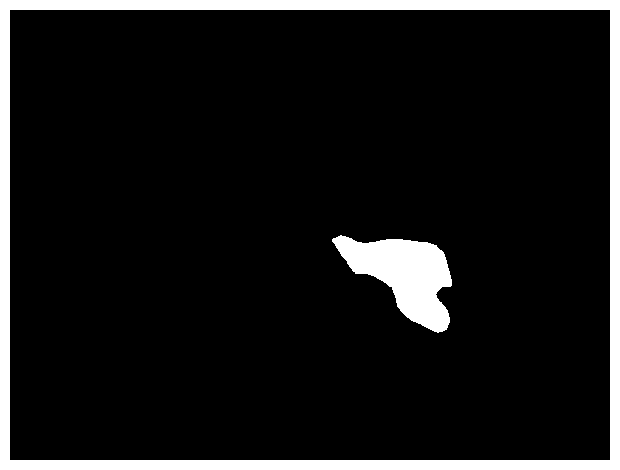

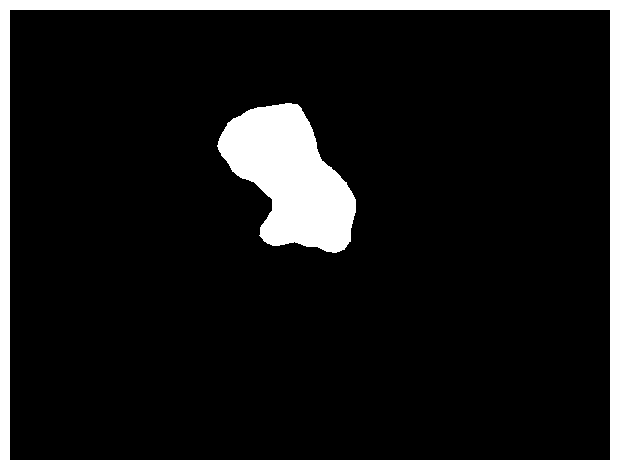

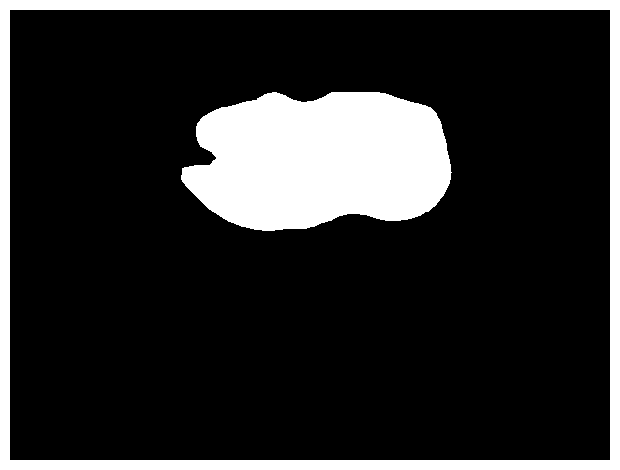

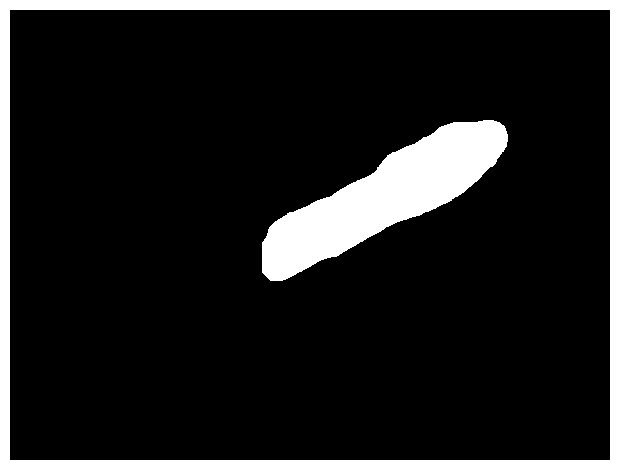

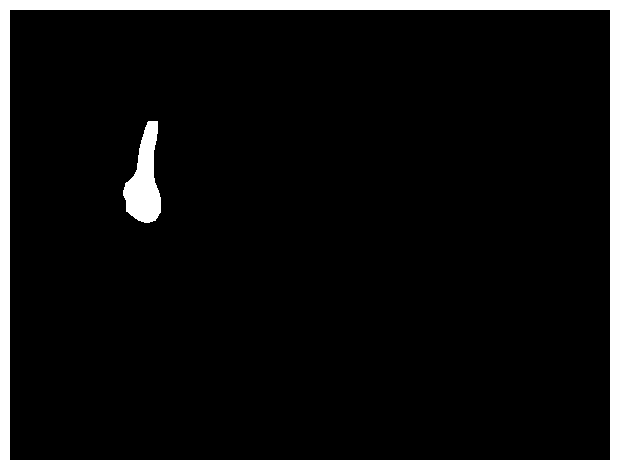

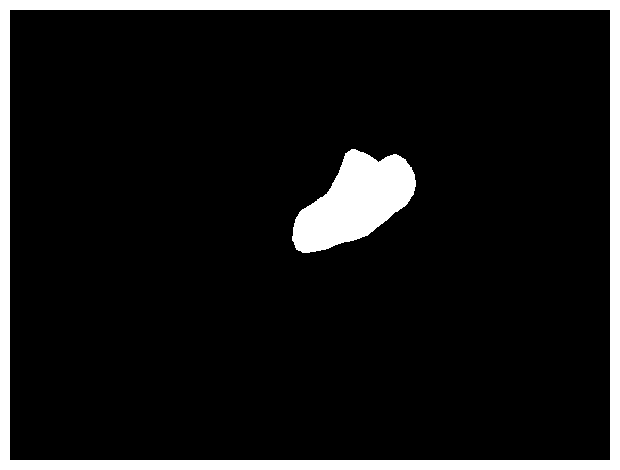

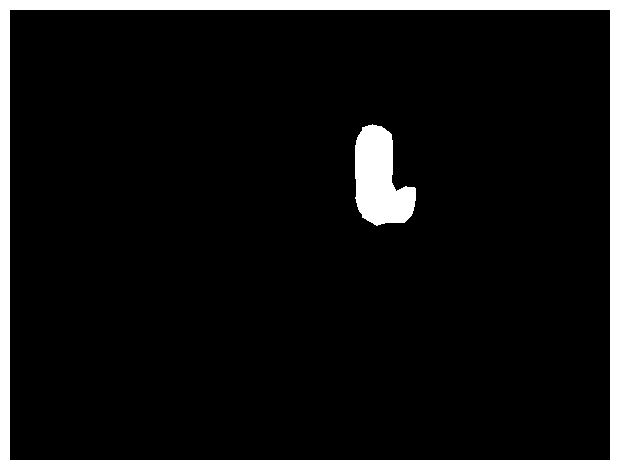

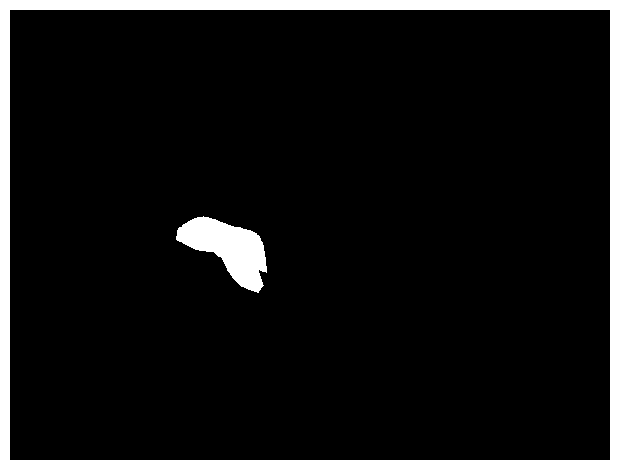

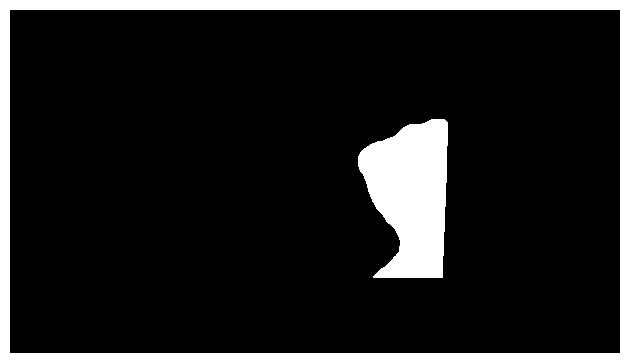

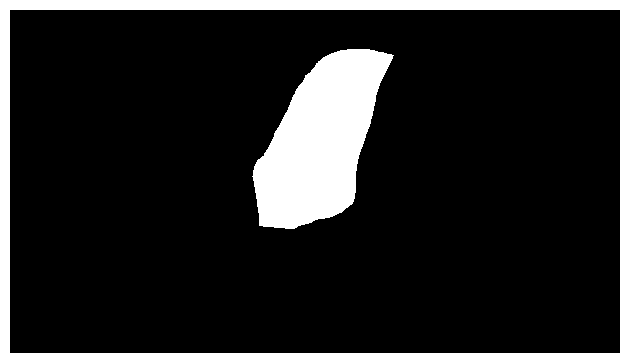

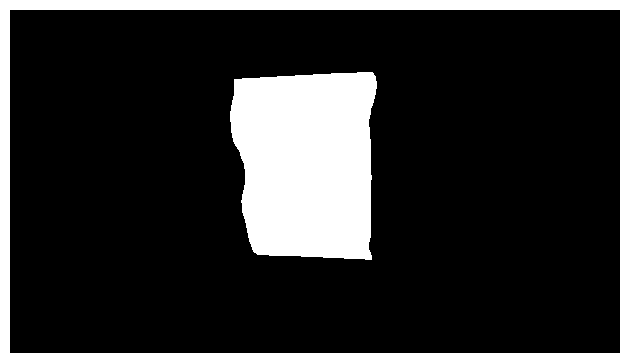

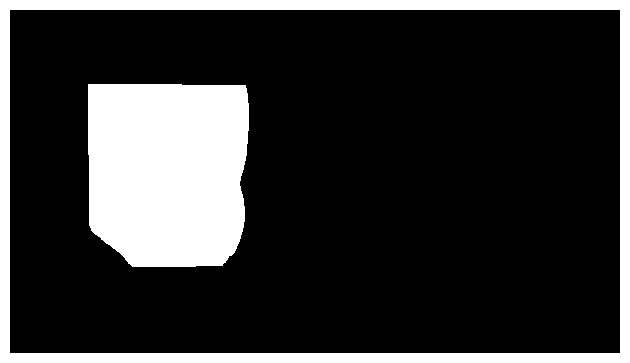

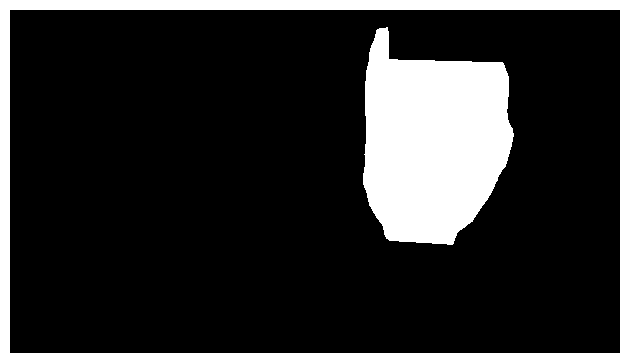

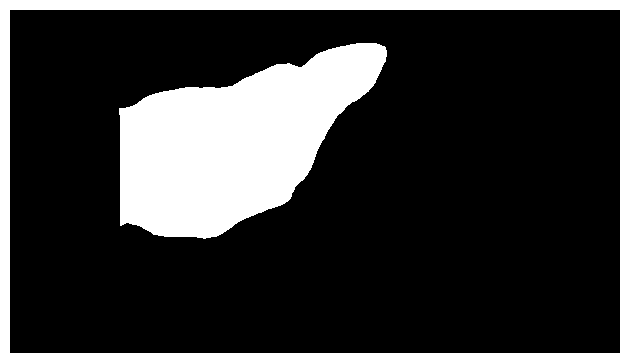

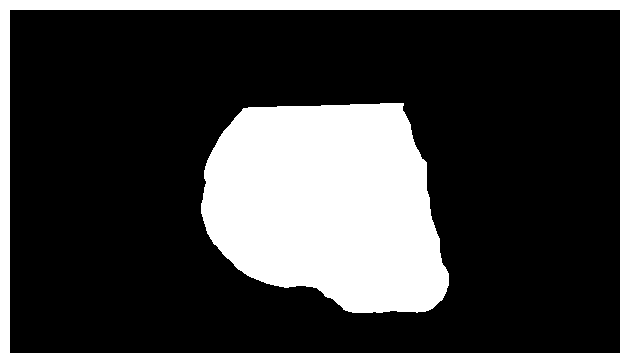

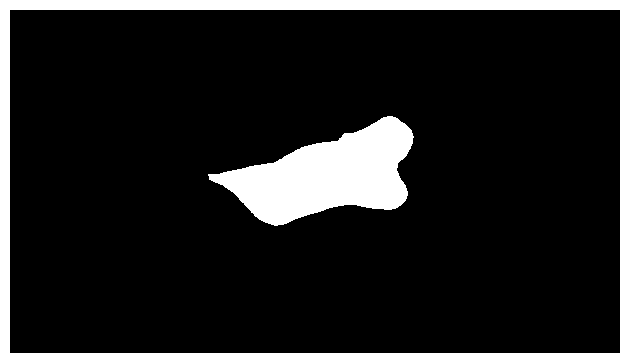

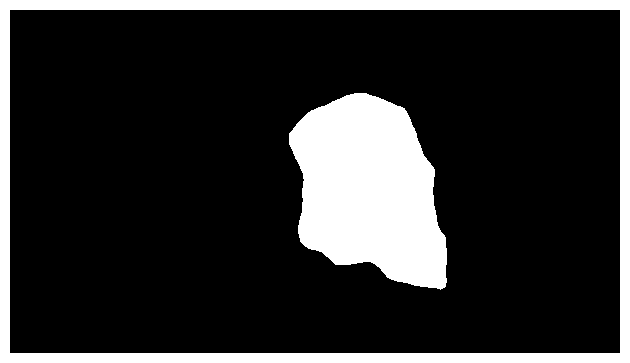

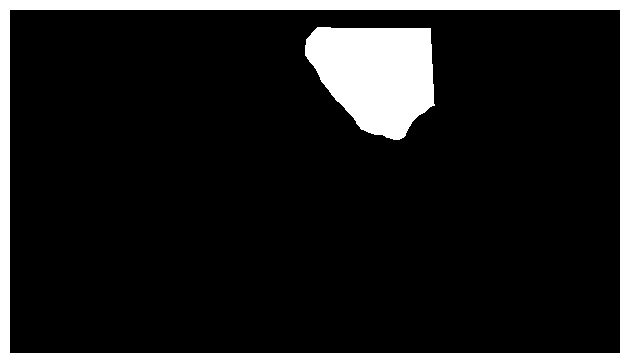

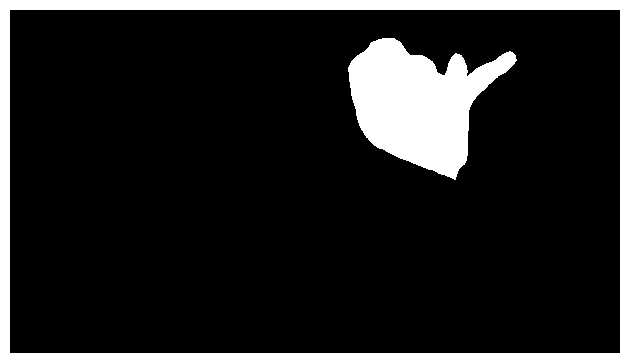

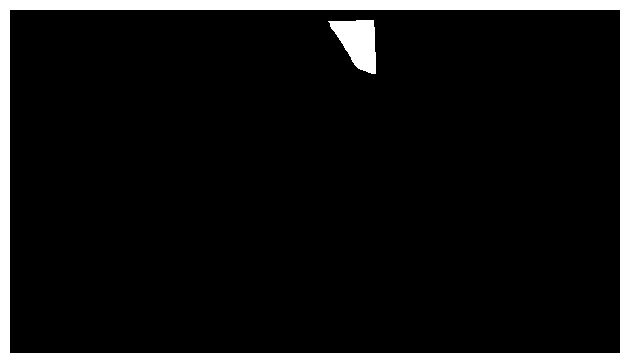

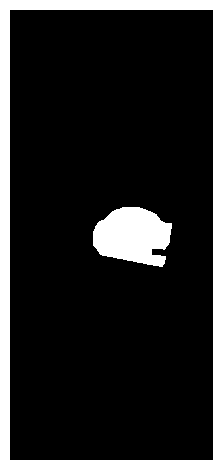

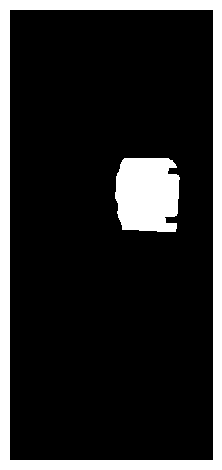

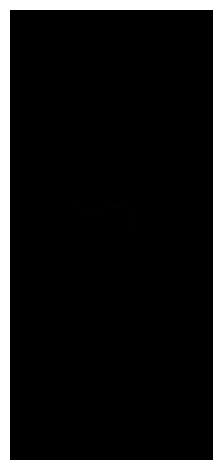

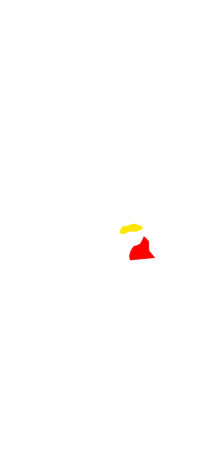

In [107]:
for i in range(len(trdt)):
    ts.show(trdt[i][1]['masks'])

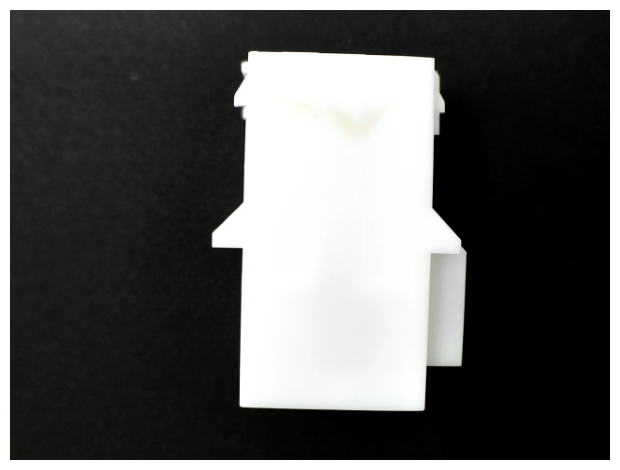

In [76]:
ts.show(trdt[0][0])

In [110]:
batch_size = 4
def collate_fn(batch):
    return tuple(zip(*batch))

trdl = torch.utils.data.DataLoader(dataset=trdt, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

In [111]:
trit = iter(trdl)

In [120]:
x,y = next(trit)